# Optimizadores en Pytorch

En este  notebook vamos a prestar una especial atención a los optimizadores en Pytorch. 

Los optimizadores se encuentran agrupados dentro del paquete torch.optim. Su rol dentro del proceso de aprendizaje es integrarse con el mecanismo de autograd de los tensores y proporcionar una implementación de la pasada *backward*. Para ello, tienen que obtener información de cómo de lejos está el modelo de la salida deseada para realizar un cálculo de los gradientes a aplicar sobre los parámetros del modelo. Las funciones de pérdida se tratan de forma separada en otro notebook.

Algunas características comunes a los optimizadores de Pytorch son:

- Mantienen el estado actual y actualizan los parámetros usando un cálculo de sus gradientes
- Tienen una interfaz común que facilita 
    - Que sean fácilmente intercambiables
    - Que se pueden implementar optimizadores ad-hoc
- Reciben un iterables con los parámetros aprendibles del modelo
    - También reciben otros parámetros, llamados hiperparámetros del optimizador, que permite su configuración (ejs. learning rate, momentum)

Métodos principales:

- *backward()*: Calcula los gradientes. Se aplica a la función de pérdida, no al optimizador.
- *zero_grad()*: Pone a 0 los gradientes del optimizador
- *step()*: Aplica los gradientes calculados por *backward()* a los parámetros del modelo

La clase base del optimizador es optim.Optimizer y recibe como parámetros:
- Un interable que contiene los parámetros a optimizar
- Un diccionario con los hiperparámetros del optimizador (lr, momentum, etc...)

A continuación iremos viendo ejemplos ilustrativos del uso de los optimizadores más comunes: SGD, RMSProp, Adagrad, Adam, Adadelta.

Empecemos por Stochastic Gradiente Descent (SGD)

In [7]:
# Importamos las bibliotecas necesarias
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import torch.nn.functional as F

# Definimos las transformaciones para los conjuntos de datos
transform = transforms.Compose([
    # Transformamos las imágenes a tensores
    transforms.ToTensor(),
    # Normalizamos los tensores con media 0.5 y desviación estándar 0.5
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

# Cargamos los conjuntos de datos CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Definimos una red convolucional simple
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 3 canales de entrada para RGB, 6 de salida, kernel de 5x5
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 clases de salida para CIFAR-10

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()

# Especificamos la función de pérdida y el optimizador
# En CrossEntropyLoss, el mejor valor de la función de pérdida es 0
criterion = nn.CrossEntropyLoss()
# SGD: Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, foreach=False, nesterov=False)

# Finalmente, entrenamos el modelo
# Durante 10 épocas
for epoch in range(10):
    running_loss = 0.0
    # Para cada lote de datos
    for i, data in enumerate(trainloader, 0):
        # Obtenemos las entradas y las etiquetas del lote del conjunto de entrenamiento
        inputs, labels = data
        # Reiniciamos los gradientes
        optimizer.zero_grad()
        # Hacemos una pasada hacia adelante
        outputs = model(inputs)
        # Calculamos la pérdida
        loss = criterion(outputs, labels)
        # Hacemos una pasada hacia atrás
        loss.backward()
        # Actualizamos los parámetros
        optimizer.step()
        # Imprimimos estadísticas
        running_loss += loss.item()
        
    print(f'Época {epoch+1}, Pérdida: {running_loss/len(trainloader)}')


Files already downloaded and verified
Files already downloaded and verified
Época 1, Pérdida: 1.7768517238709627
Época 2, Pérdida: 1.3932885832493873
Época 3, Pérdida: 1.2550515693319424
Época 4, Pérdida: 1.158853273943562
Época 5, Pérdida: 1.0884042653586248
Época 6, Pérdida: 1.0276772107004815
Época 7, Pérdida: 0.973789001745946
Época 8, Pérdida: 0.9205946205445873
Época 9, Pérdida: 0.8784698215134613
Época 10, Pérdida: 0.8438497624738747


En la celda anterior, podemos hacer distintas ejecuciones cambiando los valores de los parámetros de la celda de construcción del optimizador:

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, foreach=False, nesterov=False)

A continuación, vamos a hacer lo mismo, pero cambiando el optimizador SGD, por Adagrad

In [7]:
# Importamos las bibliotecas necesarias
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import torch.nn.functional as F
# Definimos las transformaciones para los conjuntos de datos
transform = transforms.Compose([
    # Transformamos las imágenes a tensores
    transforms.ToTensor(),
    # Normalizamos los tensores con media 0.5 y desviación estándar 0.5
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

# Cargamos los conjuntos de datos CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Definimos una red convolucional simple
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 3 canales de entrada para RGB, 6 de salida, kernel de 5x5
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 clases de salida para CIFAR-10

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()

# Especificamos la función de pérdida y el optimizador
# En CrossEntropyLoss, el mejor valor de la función de pérdida es 0
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [ ]:

# Adagrad
optimizer = optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)

# Finalmente, entrenamos el modelo
# Durante 10 épocas
for epoch in range(10):
    running_loss = 0.0
    # Para cada lote de datos
    for i, data in enumerate(trainloader, 0):
        # Obtenemos las entradas y las etiquetas del lote del conjunto de entrenamiento
        inputs, labels = data
        # Reiniciamos los gradientes
        optimizer.zero_grad()
        # Hacemos una pasada hacia adelante
        outputs = model(inputs)
        # Calculamos la pérdida
        loss = criterion(outputs, labels)
        # Hacemos una pasada hacia atrás
        loss.backward()
        # Actualizamos los parámetros
        optimizer.step()
        # Imprimimos estadísticas
        running_loss += loss.item()
        
    print(f'Época {epoch+1}, Pérdida: {running_loss/len(trainloader)}')

Observamos cuál es la diferencia en tiempo de ejecución, y en el valor de la función de pérdida alcanzado después de las 10 epochs.

Podemos hacer cambios en los parámetros del constructor del optimizador:

optimizer = optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)

y ver qué influencia tienen estos cambios en el tiempo de ejecución y en la precisión final alcanzada tras las 10 epochs. 

Ahora, vamos a probar sucesivamente los optimizadores RMSProp y Adam con el mismo ejemplo

In [8]:
# RMSprop
optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
# Finalmente, entrenamos el modelo
# Durante 10 épocas
for epoch in range(10):
    running_loss = 0.0
    # Para cada lote de datos
    for i, data in enumerate(trainloader, 0):
        # Obtenemos las entradas y las etiquetas del lote del conjunto de entrenamiento
        inputs, labels = data
        # Reiniciamos los gradientes
        optimizer.zero_grad()
        # Hacemos una pasada hacia adelante
        outputs = model(inputs)
        # Calculamos la pérdida
        loss = criterion(outputs, labels)
        # Hacemos una pasada hacia atrás
        loss.backward()
        # Actualizamos los parámetros
        optimizer.step()
        # Imprimimos estadísticas
        running_loss += loss.item()
        
    print(f'Época {epoch+1}, Pérdida: {running_loss/len(trainloader)}')

Época 1, Pérdida: 4.350290635662615
Época 2, Pérdida: 1.7119790146417935
Época 3, Pérdida: 1.6144331010711162
Época 4, Pérdida: 1.5453425831806935
Época 5, Pérdida: 1.4896152059135535
Época 6, Pérdida: 1.4534931237740285
Época 7, Pérdida: 1.4303689374185888
Época 8, Pérdida: 1.4178671717186413
Época 9, Pérdida: 1.3916981996935043
Época 10, Pérdida: 1.3754545522620305


In [9]:
# Adam
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# Finalmente, entrenamos el modelo
# Durante 10 épocas
for epoch in range(10):
    running_loss = 0.0
    # Para cada lote de datos
    for i, data in enumerate(trainloader, 0):
        # Obtenemos las entradas y las etiquetas del lote del conjunto de entrenamiento
        inputs, labels = data
        # Reiniciamos los gradientes
        optimizer.zero_grad()
        # Hacemos una pasada hacia adelante
        outputs = model(inputs)
        # Calculamos la pérdida
        loss = criterion(outputs, labels)
        # Hacemos una pasada hacia atrás
        loss.backward()
        # Actualizamos los parámetros
        optimizer.step()
        # Imprimimos estadísticas
        running_loss += loss.item()
        
    print(f'Época {epoch+1}, Pérdida: {running_loss/len(trainloader)}')

Época 1, Pérdida: 1.1669400319876269
Época 2, Pérdida: 1.108642712654665
Época 3, Pérdida: 1.0825879107350889
Época 4, Pérdida: 1.058956936039888
Época 5, Pérdida: 1.0396547212320215
Época 6, Pérdida: 1.022629377329746
Época 7, Pérdida: 1.0058141559591074
Época 8, Pérdida: 0.9915005305539006
Época 9, Pérdida: 0.9772829066609483
Época 10, Pérdida: 0.964328788278048


En los dos casos anteriores, podemos hacer las mismas pruebas de variación de hiperparámetros que hicimos con los otros dos optimizadores, y observar el efecto que tienen. 

## Ajuste del Learning Rate

En los ejemplos anteriores, hemos fijado el *Learning Rate* (*lr*) en el momento de creación del optimizador, como un parámetro del mismo. Es cierto, que algunos de esos algoritmos van adaptando el *lr* de forma dinámica, en función de datos estadísticos del entrenamiento, pero también existe otro mecanismo que permite adaptar el learning rate dinámicamente, desde fuera del optimizador. Ambos mecanismos se pueden usar de forma conjunta, pero esto podría producir efectos inesperados. Lo habitual, sería utilizar estos mecanismo adaptación en conjunción con optimizadores como SGD que no incorporan un mecanismo de este tipo.

Exploremos su uso, recuperando la versión SGD de nuestro ejemplo. En ella, usamos uno de estos planificadores (StepLR). A modo informativo, imprimimos el *lr* al final de cada epoch, para poder observar las actualizaciones realizadas.


In [14]:

from torch.optim import lr_scheduler
# SGD: Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, foreach=False, nesterov=False)
# Creamos un programador de tasa de aprendizaje
# Cada 7 épocas, la tasa de aprendizaje se multiplicará por 0.1
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# Finalmente, entrenamos el modelo
# Durante 10 épocas
for epoch in range(10):
    running_loss = 0.0
    # Para cada lote de datos
    for i, data in enumerate(trainloader, 0):
        # Obtenemos las entradas y las etiquetas del lote del conjunto de entrenamiento
        inputs, labels = data
        # Reiniciamos los gradientes
        optimizer.zero_grad()
        # Hacemos una pasada hacia adelante
        outputs = model(inputs)
        # Calculamos la pérdida
        loss = criterion(outputs, labels)
        # Hacemos una pasada hacia atrás
        loss.backward()
        # Actualizamos los parámetros usando el step del optimizador
        optimizer.step()
        # Imprimimos estadísticas
        running_loss += loss.item()
        
    print(f'Época {epoch+1}, Pérdida: {running_loss/len(trainloader)}')
    # Actualizamos el lr usando el step del planifcador de lr
    scheduler.step()
    print(f'Época {epoch+1}, Pérdida: {running_loss/len(trainloader)}, Tasa de aprendizaje: {scheduler.get_lr()[0]}')



Época 1, Pérdida: 1.0616193891638686
Época 1, Pérdida: 1.0616193891638686, Tasa de aprendizaje: 0.01


/home/diegoandrade/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Época 2, Pérdida: 1.060785426584351
Época 2, Pérdida: 1.060785426584351, Tasa de aprendizaje: 0.0001
Época 3, Pérdida: 0.9327894711433469
Época 3, Pérdida: 0.9327894711433469, Tasa de aprendizaje: 0.001
Época 4, Pérdida: 0.9176132407639642
Época 4, Pérdida: 0.9176132407639642, Tasa de aprendizaje: 1e-05
Época 5, Pérdida: 0.9062913428334629
Época 5, Pérdida: 0.9062913428334629, Tasa de aprendizaje: 0.0001
Época 6, Pérdida: 0.9046423651678178
Época 6, Pérdida: 0.9046423651678178, Tasa de aprendizaje: 1.0000000000000002e-06
Época 7, Pérdida: 0.9033941689049801
Época 7, Pérdida: 0.9033941689049801, Tasa de aprendizaje: 1e-05
Época 8, Pérdida: 0.9037410588673008
Época 8, Pérdida: 0.9037410588673008, Tasa de aprendizaje: 1.0000000000000002e-07
Época 9, Pérdida: 0.9031907985429934
Época 9, Pérdida: 0.9031907985429934, Tasa de aprendizaje: 1.0000000000000002e-06
Época 10, Pérdida: 0.902754614496475
Época 10, Pérdida: 0.902754614496475, Tasa de aprendizaje: 1.0000000000000004e-08


Probamos ahora, con un planificador más sofisticado: *CosineAnnealingLR*

In [16]:

from torch.optim import lr_scheduler
# SGD: Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, foreach=False, nesterov=False)
# Creamos un programador de tasa de aprendizaje
# Cada 7 épocas, la tasa de aprendizaje se multiplicará por 0.1
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=2, eta_min=0)

# Finalmente, entrenamos el modelo
# Durante 10 épocas
for epoch in range(10):
    running_loss = 0.0
    # Para cada lote de datos
    for i, data in enumerate(trainloader, 0):
        # Obtenemos las entradas y las etiquetas del lote del conjunto de entrenamiento
        inputs, labels = data
        # Reiniciamos los gradientes
        optimizer.zero_grad()
        # Hacemos una pasada hacia adelante
        outputs = model(inputs)
        # Calculamos la pérdida
        loss = criterion(outputs, labels)
        # Hacemos una pasada hacia atrás
        loss.backward()
        # Actualizamos los parámetros usando el step del optimizador
        optimizer.step()
        # Imprimimos estadísticas
        running_loss += loss.item()
        
    print(f'Época {epoch+1}, Pérdida: {running_loss/len(trainloader)}')
    # Actualizamos el lr usando el step del planifcador de lr
    scheduler.step()
    print(f'Época {epoch+1}, Pérdida: {running_loss/len(trainloader)}, Tasa de aprendizaje: {scheduler.get_lr()[0]}')



Época 1, Pérdida: 2.297729554688534
Época 1, Pérdida: 2.297729554688534, Tasa de aprendizaje: 0.025
Época 2, Pérdida: 2.30465518818487
Época 2, Pérdida: 2.30465518818487, Tasa de aprendizaje: 0.0
Época 3, Pérdida: 2.3037346436849337
Época 3, Pérdida: 2.3037346436849337, Tasa de aprendizaje: 0.09999999999999999
Época 4, Pérdida: 2.30509191644771
Época 4, Pérdida: 2.30509191644771, Tasa de aprendizaje: 0.2000000000000001
Época 5, Pérdida: 2.3061529745531204
Época 5, Pérdida: 2.3061529745531204, Tasa de aprendizaje: 0.02500000000000002
Época 6, Pérdida: 2.3040546550775125
Época 6, Pérdida: 2.3040546550775125, Tasa de aprendizaje: 0.0
Época 7, Pérdida: 2.3047193660760477
Época 7, Pérdida: 2.3047193660760477, Tasa de aprendizaje: 0.09999999999999999
Época 8, Pérdida: 2.3044501354017526
Época 8, Pérdida: 2.3044501354017526, Tasa de aprendizaje: 0.20000000000000015
Época 9, Pérdida: 2.3063098192214966
Época 9, Pérdida: 2.3063098192214966, Tasa de aprendizaje: 0.02500000000000003
Época 10, Pér

## Promediado de pesos

El promediado de pesos, Stochastic Weight Averaging (SWA) permite mejorar la capacidad de generalización del modelo, promediando sus pesos durante un determinado número de iteraciones. 

El promedio se hace en base a varios puntos de la trayectoria de optimización. Vamos a ver un ejemplo comentado del uso de esta técnica en el ejemplo que hemos uso durante este notebook.

In [19]:

from torch.optim import lr_scheduler
# SGD: Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, foreach=False, nesterov=False)
# Creamos un programador de tasa de aprendizaje
# Cada 7 épocas, la tasa de aprendizaje se multiplicará por 0.1
swa_model=torch.optim.swa_utils.AveragedModel(model)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
swa_start=5
swa_scheduler = torch.optim.swa_utils.SWALR(optimizer, swa_lr=0.05)

# Finalmente, entrenamos el modelo
# Durante 10 épocas
for epoch in range(10):
    running_loss = 0.0
    # Para cada lote de datos
    for i, data in enumerate(trainloader, 0):
        # Obtenemos las entradas y las etiquetas del lote del conjunto de entrenamiento
        inputs, labels = data
        # Reiniciamos los gradientes
        optimizer.zero_grad()
        # Hacemos una pasada hacia adelante
        outputs = model(inputs)
        # Calculamos la pérdida
        loss = criterion(outputs, labels)
        # Hacemos una pasada hacia atrás
        loss.backward()
        # Actualizamos los parámetros usando el step del optimizador
        optimizer.step()
        # Imprimimos estadísticas
        running_loss += loss.item()
        
    print(f'Época {epoch+1}, Pérdida: {running_loss/len(trainloader)}')
    # Actualizamos el lr usando el step del planifcador de lr
    if epoch>swa_start:
        swa_model.update_parameters(model)
        swa_scheduler.step()
        print(f'SWA: Época {epoch+1}, Pérdida: {running_loss/len(trainloader)}, Tasa de aprendizaje: {swa_scheduler.get_lr()[0]}')

    else:
        scheduler.step()
        print(f'Época {epoch+1}, Pérdida: {running_loss/len(trainloader)}, Tasa de aprendizaje: {scheduler.get_lr()[0]}')

torch.optim.swa_utils.update_bn(trainloader, swa_model)



Época 1, Pérdida: 2.303076273644977
Época 1, Pérdida: 2.303076273644977, Tasa de aprendizaje: 0.01
Época 2, Pérdida: 2.3029927542752318
Época 2, Pérdida: 2.3029927542752318, Tasa de aprendizaje: 0.0001
Época 3, Pérdida: 2.3028522071326174
Época 3, Pérdida: 2.3028522071326174, Tasa de aprendizaje: 0.001
Época 4, Pérdida: 2.3026863049973003
Época 4, Pérdida: 2.3026863049973003, Tasa de aprendizaje: 1e-05
Época 5, Pérdida: 2.3026124556046312
Época 5, Pérdida: 2.3026124556046312, Tasa de aprendizaje: 0.0001
Época 6, Pérdida: 2.3026079335785887
Época 6, Pérdida: 2.3026079335785887, Tasa de aprendizaje: 1.0000000000000002e-06
Época 7, Pérdida: 2.3026005593712067
SWA: Época 7, Pérdida: 2.3026005593712067, Tasa de aprendizaje: 0.002426747431602186


/home/diegoandrade/.local/lib/python3.10/site-packages/torch/optim/swa_utils.py:286: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Época 8, Pérdida: 2.302675015176349
SWA: Época 8, Pérdida: 2.302675015176349, Tasa de aprendizaje: 0.00807543310363525
Época 9, Pérdida: 2.302821895960347
SWA: Época 9, Pérdida: 2.302821895960347, Tasa de aprendizaje: 0.015166747979240275
Época 10, Pérdida: 2.302918765855872
SWA: Época 10, Pérdida: 2.302918765855872, Tasa de aprendizaje: 0.023025590457044103


# Ejercicio

Ahora vamos a hacer un ejercicio sobre optimizadores. El objetivo es probar distintos algoritmos de optimización sobre un mismo ejemplo y comparar su desempeño.
El código está preparado para entrenar la misma red con tres algoritmos de optimización distintos: SGD, Adam y RMSProp. La parte del código que falta es la definición del uso de los optimizadores Adam y RMSProp, proporcionándose el código de SGD como referencia.

Al final de los tres entrenamientos, se imprime una gráfica comparando la evolución de la función de pérdida en el entrenamiento, cuando se usan cada uno de los 3 optimizadores.



Files already downloaded and verified


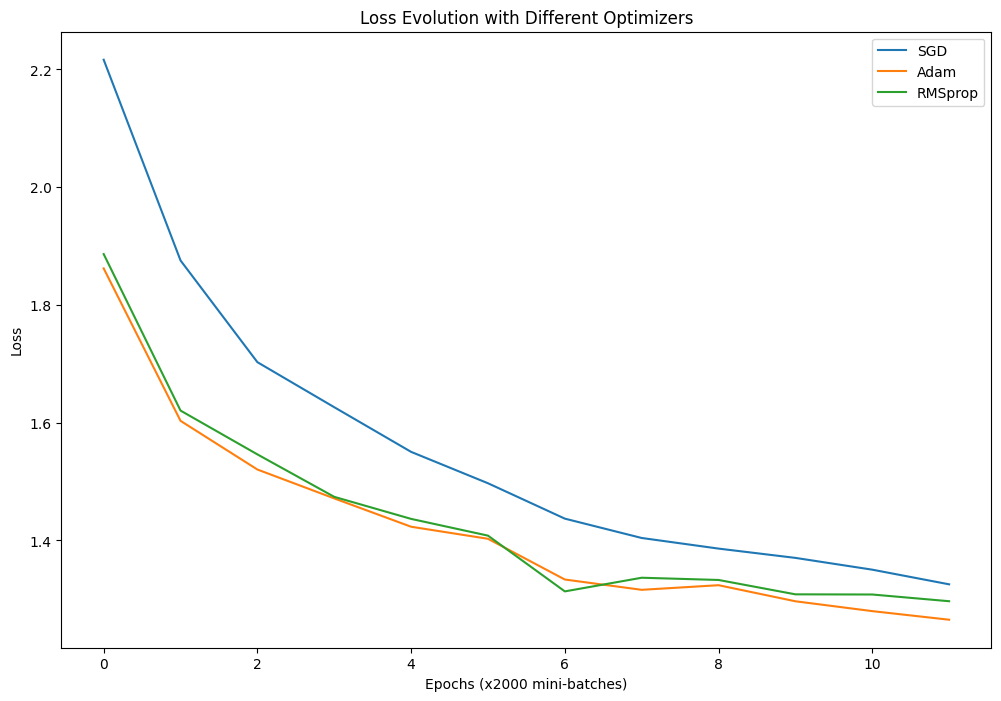

In [2]:
# Import libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Define the network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the loss function
loss_func = nn.CrossEntropyLoss()

# Define the training function
def train(net, trainloader, optimizer, num_epochs=2):
    loss_values = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            # save losses to plot later
            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                loss_values.append(running_loss / 2000)
                running_loss = 0.0
    return loss_values

# SGD
net_SGD = Net()
optimizer_SGD = optim.SGD(net_SGD.parameters(), lr=0.001, momentum=0.9)
loss_SGD = train(net_SGD, trainloader, optimizer_SGD)

# Adam
net_Adam = Net()
# Escribe tu código aquí
# ...
# optimizer_Adam = optim.Adam(net_Adam.parameters(), lr=0.001)
# loss_Adam = train(net_Adam, trainloader, optimizer_Adam)

# RMSprop
net_RMSprop = Net()
# Escribe tu código aquí
# ...
# optimizer_RMSprop = optim.RMSprop(net_RMSprop.parameters(), lr=0.001)
# loss_RMSprop = train(net_RMSprop, trainloader, optimizer_RMSprop)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(loss_SGD, label='SGD')
plt.plot(loss_Adam, label='Adam')
plt.plot(loss_RMSprop, label='RMSprop')
plt.xlabel('Epochs (x2000 mini-batches)')
plt.ylabel('Loss')
plt.title('Loss Evolution with Different Optimizers')
plt.legend()
plt.show()
